# Initialization

In [ ]:
%%bash

git clone git://github.com/matt-peters/allennlp.git
cd allennlp 
git checkout 2d7ba1cb108428aaffe2dce875648253b44cb5ba
pip install --no-deps -e ./
pip install boto3 overrides==3.1 editdistance ftfy pytorch_pretrained_bert nltk unidecode parsimonious word2number conllu==0.11
pip install flask_cors gevent numpydoc tensorboardX jsonnet responses flaky moto awscli "spacy>=2.0,<2.1" "urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1" fire

In [ ]:
!python -c 'from allennlp.data.dataset_readers.dataset_reader import DatasetReader'

In [ ]:
%%bash

git clone https://github.com/allenai/kb.git
cd kb 
pip install --editable .
python -c "import nltk; nltk.download('wordnet')"
python -m spacy download en_core_web_sm

In [ ]:
!wget https://raw.githubusercontent.com/IINemo/knowbert_seminar/master/knowbert_custom.py
!wget https://raw.githubusercontent.com/IINemo/knowbert_seminar/master/knowbert_utils_custom.py
!wget https://raw.githubusercontent.com/IINemo/knowbert_seminar/master/knowbert_infer.py
!wget https://raw.githubusercontent.com/IINemo/knowbert_seminar/master/kb_config_default.jsonnet
!wget https://raw.githubusercontent.com/IINemo/knowbert_seminar/master/kb_config_cosine.jsonnet
!wget https://raw.githubusercontent.com/IINemo/knowbert_seminar/master/kb_config_original.jsonnet

In [ ]:
%%bash

export ALLENNLP_CACHE_ROOT=./ 
allennlp train -s OUTPUT_DIRECTORY --force --file-friendly-logging \
--include-package knowbert_custom \
./kb_config_default.jsonnet

# Entity Linking

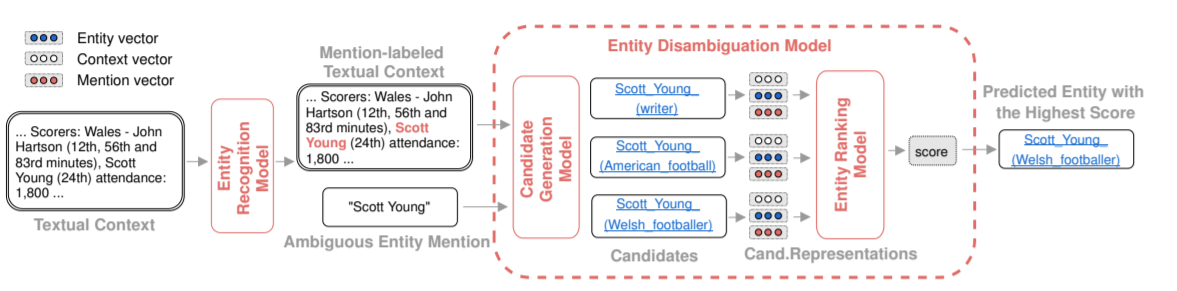

# General Entity Linking Architecture

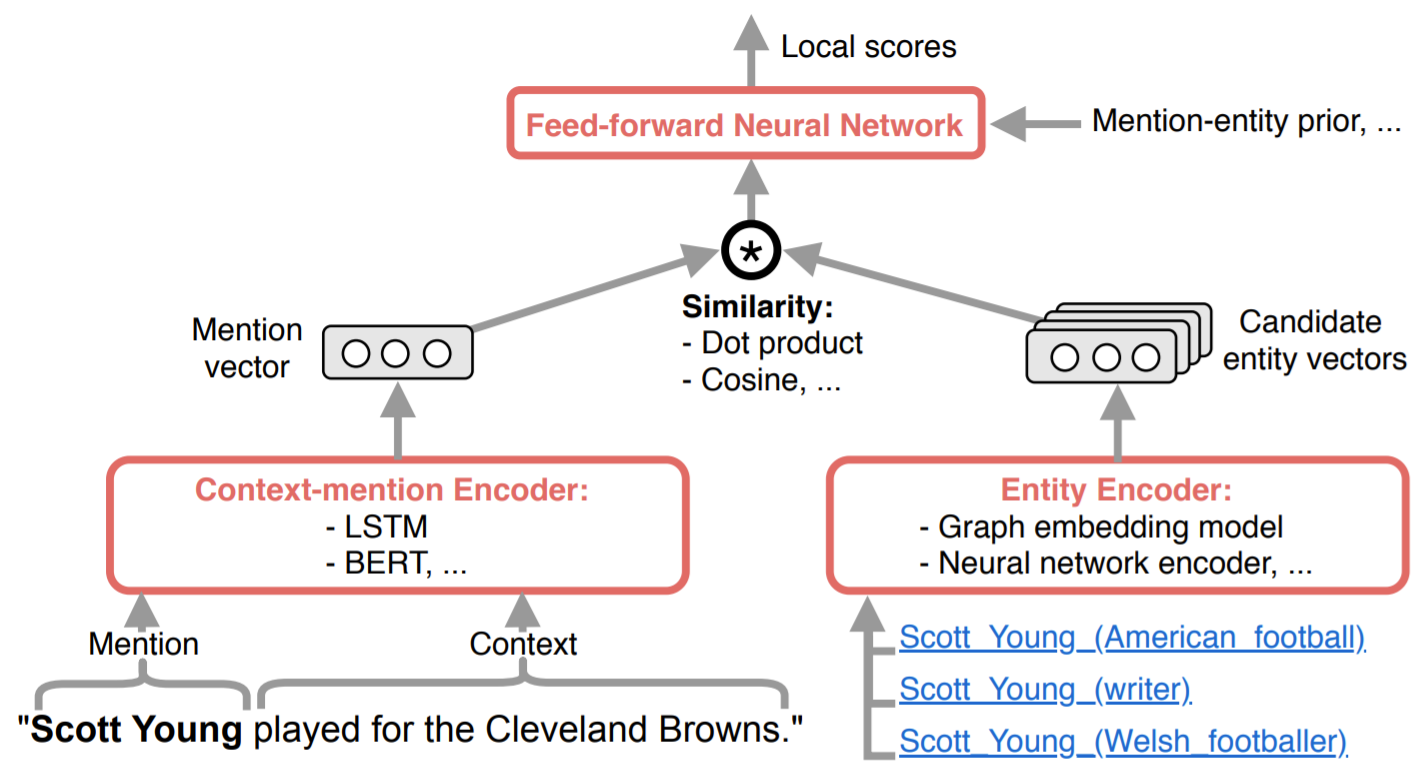

# KnowBERT

Paper: https://www.aclweb.org/anthology/D19-1005.pdf

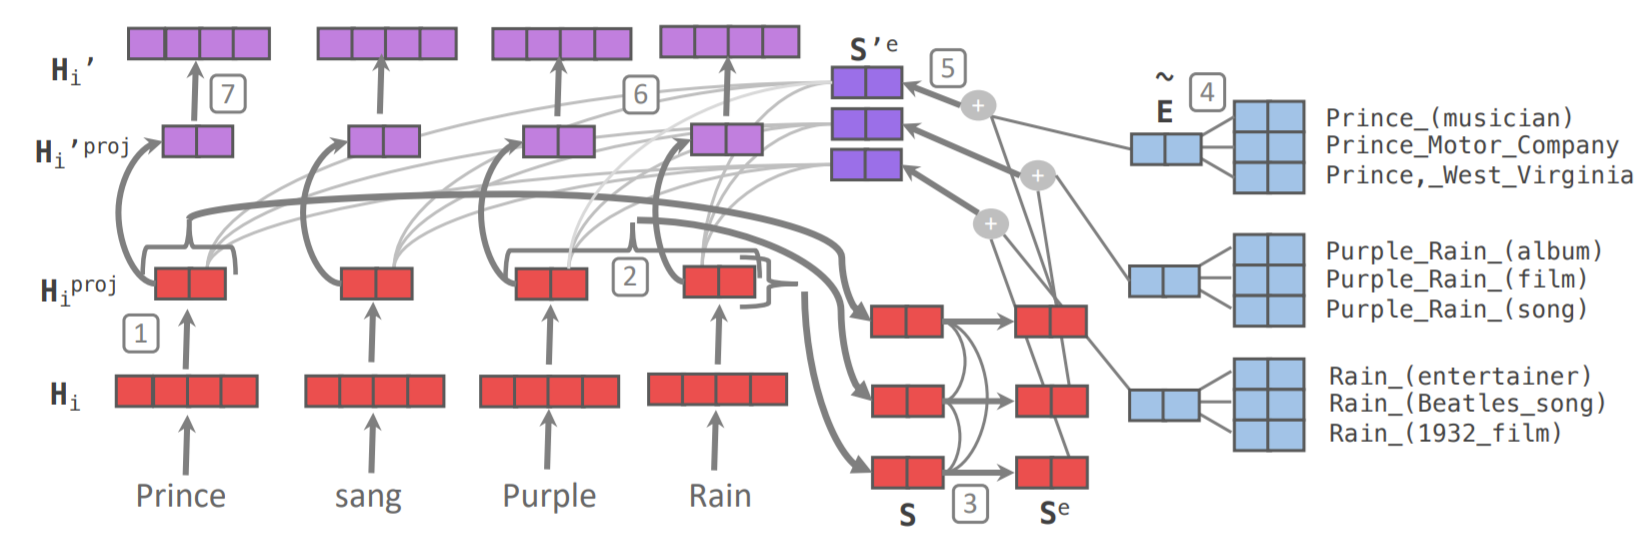

# Data

In [ ]:
%%bash

mkdir data
cd data
wget https://allennlp.s3-us-west-2.amazonaws.com/knowbert/wiki_entity_linking/aida_train.txt

In [ ]:
!head -n 600 data/aida_train.txt | tail -n 100

# Train model

In [ ]:
!export ALLENNLP_CACHE_ROOT=./ ; \
allennlp train -s OUTPUT_DIRECTORY --force --file-friendly-logging \
--include-package knowbert_custom \
./kb_config_default.jsonnet

# jsonnet config

# Implementation of KnowBERT

1. KnowBERT general implementation. (kb/kb/knowbert.py->KnowBert)
2. Generation of span candidates. (kb/kb/wiki_linking_util.py->WikiCandidateMentionGenerator line 240)

In [ ]:
from allennlp.data.dataset_readers.dataset_utils import enumerate_spans

tokens = 'George Bush is living in London in a yellow submarine that goes under the water .'.split()
all_spans = enumerate_spans(tokens, max_span_width=5, filter_function=None)
[tokens[e[0] : e[1]+1] for e in all_spans]

3. Entity candidates. (kb/kb/wiki_linking_util.py -> WikiCandidateMentionGenerator -> line 277)
4. Entity embeddings (kb/kb/knowbert.py -> EntityDisambiguator -> line 349).
The entity embeddings use a skipgram like objective to learn 300-dimensional embeddings of Wikipedia Following BERT, for 80% of masked word pieces all
candidates are replaced with [MASK], 10% are replaced with random candidates and 10% left unmasked. page titles directly from Wikipedia descriptions without using any explicit graph structure between nodes. As such, nodes in the KB are Wikipedia page titles, e.g., Prince (musician). Ganea and Hofmann (2017) provide pretrained embeddings for a subset of approximately 470K entities. Early experiments with embeddings derived from Wikidata relations4 did not improve results.


5. Span encoding. (kb/kb/knowbert.py -> EntityDisambiguator (SelfAttentiveSpanExtractor line 498)
6. Entity disambiguation (kb/kb/knowbert.py -> EntityDisambiguator (span_encoder, dot_attention_with_prior, DotAttentionWithPrior).
7. Loss function.
8. Modifications.

# Predict

In [ ]:
import torch
device = torch.device('cuda')

import numpy as np

from allennlp.common.file_utils import cached_path
from allennlp.models.archival import load_archive
from allennlp.nn.util import move_to_device
from allennlp.common import Params

In [ ]:
entities_path = "https://allennlp.s3-us-west-2.amazonaws.com/knowbert/wiki_entity_linking/entities_glove_format.gz"
vocabulary_path = "https://allennlp.s3-us-west-2.amazonaws.com/knowbert/models/vocabulary_wiki.tar.gz"

In [ ]:
from allennlp.common import Params


WIKI_CANDIDATE_GENERATOR = Params({
                        "type": "bert_tokenizer_and_candidate_generator",
                        "entity_candidate_generators": {
                            "wiki": {"type": "wiki"},
                        },
                        "entity_indexers":  {
                            "wiki": {
                                   "type": "characters_tokenizer",
                                   "tokenizer": {
                                       "type": "word",
                                       "word_splitter": {"type": "just_spaces"},
                                   },
                                   "namespace": "entity"
                                }
                        },
        "bert_model_type": "bert-base-uncased",
        "do_lower_case": True
})

In [ ]:
from knowbert_custom import *
from knowbert_utils_custom import KnowBertBatchifierCustom


model_url = './OUTPUT_DIRECTORY/model.tar.gz'

archive = load_archive(model_url)
batcher = KnowBertBatchifierCustom(model_url, candidate_generator_params=WIKI_CANDIDATE_GENERATOR)
tokenizer = batcher.tokenizer_and_candidate_generator.bert_tokenizer

model = archive.model
model.to(device)
_ = model.eval()

In [ ]:
from allennlp.modules.token_embedders import Embedding
from allennlp.common import Params
from allennlp.data import Vocabulary

vocab = Vocabulary.from_files(vocabulary_path)


entity_embedding = Embedding.from_params(vocab, 
                                         params=Params(
                                             dict(vocab_namespace="entity",
                                             embedding_dim=300,
                                             pretrained_file=entities_path,
                                             trainable=False,
                                             sparse=False))
                                        )

In [ ]:
from torch.utils.data import DataLoader

with torch.no_grad():
    data_loader = DataLoader(entity_embedding.weight, batch_size=64)
    
    results = []
    for batch in data_loader:
        results.append(model.soldered_kgs['wiki'].entity_linker.disambiguator.kg_layer_norm(batch.cuda()).cpu())
        
    processed_embeddings = torch.cat(results, dim=0)
    
entity_embedding.weight = torch.nn.Parameter(processed_embeddings)

In [ ]:
def get_entity_embedding(entity_embedding, vocab, entity_str):
    return entity_embedding(torch.LongTensor([[vocab.get_token_index(entity_str, namespace='entity')]]))

In [ ]:
text = 'George Bush is a president of United States.'
#text = 'We are living in New York city.'
sentences = [text]

batch = next(batcher.iter_batches(sentences, verbose=False))
b = move_to_device(batch, 0)
with torch.no_grad():
    model_output = model(**b)

In [ ]:
n_span_candidates = model_output['wiki']['linking_scores'].shape[1]
full_matrix = entity_embedding._parameters['weight']
candidate_entities = np.array([[e for e in range(full_matrix.shape[0])] 
                               for _ in range(n_span_candidates)], dtype=np.int)

In [ ]:
candidate_entities = batch['candidates']['wiki']['candidate_entities']['ids'].squeeze(0).numpy()

In [ ]:
from torch.nn import CosineSimilarity

sim_cosine = CosineSimilarity(dim=-1)
similarity_measure = sim_cosine

In [ ]:
def compare_span_candidate(i, candidate_entities):
    span = batch['candidates']['wiki']['candidate_spans'][0][i]
    print_sent = sent[:span[0]] + ['==>'] + sent[span[0] : span[1] + 1] + ['<=='] + sent[span[1] + 1:]
    print('\n\n=============', ' '.join(print_sent))
    context_vector = model_output['wiki']['projected_span_representations'][0, i, :].cpu()
    entity_embedding_compare = entity_embedding._parameters['weight'][candidate_entities[i]]
    
    scores = similarity_measure(context_vector, entity_embedding_compare)
    #print(dot_products[vocab.get_token_index('George_H._W._Bush', namespace='entity')])
    
    top_indexes = torch.argsort(scores, descending=True)[:n_top].numpy()
    for j, ind in enumerate(candidate_entities[i, top_indexes]):
        print('{} ({})'.format(vocab.get_token_from_index(ind, namespace='entity'), scores[top_indexes[j]].detach().numpy()))

In [ ]:
from knowbert_infer import idxs_to_tokens

n_top = 50

token_idxs = batch['tokens']['tokens']
sent = idxs_to_tokens(token_idxs, tokenizer)[0]

for i in range(n_span_candidates):
    compare_span_candidate(i, candidate_entities)